# **0) Preparación**

In [84]:
%pip install -q agentpy numpy pandas matplotlib seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# **1) Imports y estilo**

In [85]:
import agentpy as ap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(context="notebook", style="whitegrid")

# **2) Parámetros del experimento**

In [86]:
# 1 tick = 1 segundo
PARAMS = {
    'steps': 60,        # 20 minutos de simulación
    'yellow': 3,
    'all_red': 1,

    # Plan fijo BASE (se puede editar)
    'green_ns': 30,
    'green_ew': 30,

    # Heurística (decisiones cada Δs, límites de verdes y umbral)
    'decide_every': 5,    # cada 5 s revisar colas
    'min_green': 10,      # no cortar antes de min_green
    'max_green': 90,      # no extender más de max_green
    'threshold': 3,       # extender si cola_NS - cola_EW > threshold (y viceversa)

    # Flujo de arribos (veh/s). Ajusta según cruce asignado
    'lambda_N': 0.15,   # ≈ 540 veh/h
    'lambda_S': 0.10,
    'lambda_E': 0.12,
    'lambda_W': 0.08,

    # Cinemática
    'v_free': 7.0,     # m/s
    'headway': 7.0,    # m

    # Geometría simple
    'L': 90.0,         # medio largo de calzada dibujada
    'w': 3.5           # ancho de carril
}

# **3) Controladores de semáforo**
3.1. Utilidades comunes

In [87]:
def lights_from_phase_sub(phase, sub):
    """Devuelve dict {'N','S','E','W'} -> 'R'/'Y'/'G' para fase 0(NS)/1(EW)."""
    L = {d:'R' for d in ['N','S','E','W']}
    if phase == 0:  # NS privilegiado
        L['N'] = L['S'] = sub
    else:           # EW privilegiado
        L['E'] = L['W'] = sub
    return L


3.2. Controlador BASE (plan fijo)

In [88]:
class FixedController(ap.Agent):
    """Fase 0=NS, fase 1=EW. Subestados: G->Y->AR con tiempos fijos."""

    def setup(self, green_ns, green_ew, yellow, all_red):
        self.g_ns, self.g_ew = int(green_ns), int(green_ew)
        self.y, self.ar = int(yellow), int(all_red)
        self.phase, self.sub, self.t_in = 0, 'G', 0
        self.timeline = []

    def step(self):
        self.timeline.append((self.model.t, self.phase, self.sub, lights_from_phase_sub(self.phase, self.sub)))
        if self.phase == 0:
            if self.sub == 'G' and self.t_in >= self.g_ns: self.sub, self.t_in = 'Y', 0
            elif self.sub == 'Y' and self.t_in >= self.y:  self.sub, self.t_in = 'AR', 0
            elif self.sub == 'AR' and self.t_in >= self.ar: self.phase, self.sub, self.t_in = 1, 'G', 0
            else: self.t_in += 1
        else:
            if self.sub == 'G' and self.t_in >= self.g_ew: self.sub, self.t_in = 'Y', 0
            elif self.sub == 'Y' and self.t_in >= self.y:  self.sub, self.t_in = 'AR', 0
            elif self.sub == 'AR' and self.t_in >= self.ar: self.phase, self.sub, self.t_in = 0, 'G', 0
            else: self.t_in += 1

    def lights(self):
        return lights_from_phase_sub(self.phase, self.sub)

    @property
    def green_dirs(self):
        return {'N','S'} if (self.phase==0 and self.sub=='G') else ({'E','W'} if (self.phase==1 and self.sub=='G') else set())


3.3. Controlador HEURÍSTICO (extiende verde si hay más cola)

Cada decide_every segundos toma una decisión.

Acciones: extend (si aún < max_green) o switch (si > min_green).

Criterio: compara cola_NS vs cola_EW con un umbral.

In [89]:
class HeuristicController(ap.Agent):
    def setup(self, p):
        self.p = p
        self.phase, self.sub, self.t_in = 0, 'G', 0
        self.timeline = []

    def lights(self):
        return lights_from_phase_sub(self.phase, self.sub)

    @property
    def green_dirs(self):
        return {'N','S'} if (self.phase==0 and self.sub=='G') else ({'E','W'} if (self.phase==1 and self.sub=='G') else set())

    def decide_action(self, qN,qS,qE,qW):
        # comparar colas por corredores
        q_ns = qN + qS
        q_ew = qE + qW
        prefer_ns = (q_ns - q_ew) > self.p['threshold']
        prefer_ew = (q_ew - q_ns) > self.p['threshold']

        # solo decide en verde y cada decide_every
        if self.sub != 'G' or (self.model.t % self.p['decide_every']) != 0:
            return None

        # reglas con mínimos y máximos
        if self.phase==0:   # NS verde
            if prefer_ns and self.t_in < self.p['max_green']:
                return 'extend'
            if self.t_in >= self.p['min_green'] and prefer_ew:
                return 'switch'
        else:               # EW verde
            if prefer_ew and self.t_in < self.p['max_green']:
                return 'extend'
            if self.t_in >= self.p['min_green'] and prefer_ns:
                return 'switch'
        # si no hay preferencia fuerte, respeta plan nominal de 30s aprox
        if self.t_in >= 30 and self.t_in >= self.p['min_green']:
            return 'switch'
        return 'extend'

    def apply_action(self, action):
        # acción sobre subestados
        if action == 'extend':
            self.t_in += 1  # simplemente no cambiamos subestado
        elif action == 'switch':
            self.sub, self.t_in = 'Y', 0

    def step(self):
        # Log
        self.timeline.append((self.model.t, self.phase, self.sub, self.lights()))

        # Tomar decisión si procede
        qN,qS,qE,qW = self.model.peek_queues()
        action = self.decide_action(qN,qS,qE,qW)
        if action is not None:
            self.apply_action(action)
            return

        # si no hubo acción (o no era tiempo de decidir), seguir ciclo normal
        if self.sub == 'G':  # avanzar tiempo interno
            self.t_in += 1
        elif self.sub == 'Y' and self.t_in >= self.p['yellow']:
            self.sub, self.t_in = 'AR', 0
        elif self.sub == 'AR' and self.t_in >= self.p['all_red']:
            self.phase = 1 - self.phase
            self.sub, self.t_in = 'G', 0
        else:
            self.t_in += 1


3.4. Controlador Q-LEARNING (básico)

Estado (discretizado): (phase, bin_ns, bin_ew) donde bin_ns es una discretización de qN+qS y bin_ew de qE+qW.

Acciones: 0=extend, 1=switch (solo válidas en verde).

Recompensa: negativa por cola total en el tick (o por espera).

Entrena por episodios; luego ejecuta explotación.

In [90]:
def bin_count(x, bins=(0,2,4,6,9)):
    # devuelve índice de bin para x (ej. 0:0, 1:1-2, 2:3-4, 3:5-6, 4:7+)
    for i,b in enumerate(bins):
        if x<=b: return i
    return len(bins)

class QLearningController(ap.Agent):

    def setup(self, p, train=True, alpha=0.3, gamma=0.9, epsilon=0.1, episodes=10):
        self.p = p
        self.alpha, self.gamma, self.epsilon = alpha, gamma, epsilon
        self.Q = {}              # diccionario: (phase,bin_ns,bin_ew) -> [Q_extend, Q_switch]
        self.train = train
        self.episodes = episodes
        # estado actual
        self.phase, self.sub, self.t_in = 0, 'G', 0
        self.timeline = []

        # para entrenamiento en línea (un solo episodio por corrida del modelo)
        self.prev_state = None
        self.prev_action = None

    def lights(self):
        return lights_from_phase_sub(self.phase, self.sub)

    @property
    def green_dirs(self):
        return {'N','S'} if (self.phase==0 and self.sub=='G') else ({'E','W'} if (self.phase==1 and self.sub=='G') else set())

    def state(self):
        qN,qS,qE,qW = self.model.peek_queues()
        bin_ns = bin_count(qN+qS)
        bin_ew = bin_count(qE+qW)
        return (self.phase, bin_ns, bin_ew)

    def qvals(self, s):
        if s not in self.Q: self.Q[s] = np.zeros(2, dtype=float)
        return self.Q[s]

    def select_action(self, s):
        # solo en verde se decide; si no, acción "pasiva" (None)
        if self.sub != 'G': return None
        if self.train and np.random.rand() < self.epsilon:
            return np.random.randint(0,2)  # explorar
        return int(np.argmax(self.qvals(s)))  # explotar

    def apply_action(self, a):
        if a is None:
            # avanzar ciclo normal
            if self.sub == 'Y' and self.t_in >= self.p['yellow']:
                self.sub, self.t_in = 'AR', 0
            elif self.sub == 'AR' and self.t_in >= self.p['all_red']:
                self.phase = 1 - self.phase
                self.sub, self.t_in = 'G', 0
            else:
                self.t_in += 1
            return

        # 0: extend, 1: switch
        if a == 0:
            self.t_in = min(self.t_in + 1, self.p['max_green'])
        else:
            # solo permitir switch si ya cumplimos min_green
            if self.t_in >= self.p['min_green']:
                self.sub, self.t_in = 'Y', 0
            else:
                self.t_in += 1  # castigo suave: no cambiar aún

    def reward(self):
        # Recompensa instantánea negativa por cola total (minimizar colas)
        qN,qS,qE,qW = self.model.peek_queues()
        total_q = qN+qS+qE+qW
        return -float(total_q)

    def step(self):
        self.timeline.append((self.model.t, self.phase, self.sub, self.lights()))
        s = self.state()
        a = self.select_action(s)

        # aplicar acción
        self.apply_action(a)

        # obtener recompensa
        r = self.reward()
        s2 = self.state()

        # actualizar Q (solo en entrenamiento)
        if self.train and a is not None:
            q = self.qvals(s)
            q_next = self.qvals(s2)
            td = r + self.gamma * np.max(q_next) - q[a]
            q[a] += self.alpha * td


# **4) Vehículos y modelo del cruce**

In [91]:
class Car(ap.Agent):
    def setup(self, origin):
        p = self.model.p
        L, w = p.L, p.w
        self.origin = origin
        self.state = 'move'
        self.v = p.v_free

        off = w/2
        if origin == 'N':
            self.pos = np.array([-off,  L]);  self.dir = np.array([0,-1])
            self.stop = np.array([-off, +2]); self.goal= np.array([-off, -L])
        elif origin == 'S':
            self.pos = np.array([ +off, -L]); self.dir = np.array([0,+1])
            self.stop = np.array([ +off, -2]); self.goal= np.array([ +off, +L])
        elif origin == 'E':
            self.pos = np.array([ +L, +off]); self.dir = np.array([-1,0])
            self.stop = np.array([ +2, +off]); self.goal= np.array([ -L, +off])
        else:
            self.pos = np.array([ -L, -off]); self.dir = np.array([+1,0])
            self.stop = np.array([ -2, -off]); self.goal= np.array([ +L, -off])

        self.arrival_t = self.model.t

    def step(self):
        if np.linalg.norm(self.pos - self.goal) < 1.0:
            # salida: registrar delay
            delay = self.model.t - self.arrival_t
            self.model.departures_log.append((self.model.t, self.origin, self.id, delay))
            self.state='done'
            return

        # zona de decisión: cerca de la línea de alto
        near = np.linalg.norm(self.pos - self.stop) < 3.0
        light = self.model.ctrl.lights()[self.origin]
        # bloquear si no hay verde
        if near and light != 'G':
            return

        # headway simple: no acercarse demasiado al líder del mismo carril
        vmax = self.v
        leader = self.model.leader_ahead(self)
        if leader is not None:
            gap = np.linalg.norm(leader.pos - self.pos)
            if gap < self.model.p.headway:
                vmax = 0.0

        # avanzar
        self.pos = self.pos + self.dir * vmax

class IntersectionModel(ap.Model):
    """Modelo común, cambia solo el controlador (Fixed/Heuristic/QLearning)."""

    def setup(self, controller='fixed', q_params=None):
        p = self.p
        if controller == 'fixed':
            self.ctrl = FixedController(self, p.green_ns, p.green_ew, p.yellow, p.all_red)
        elif controller == 'heuristic':
            self.ctrl = HeuristicController(self, p)
        elif controller == 'qlearning':
            q_defaults = {'alpha':0.3, 'gamma':0.9, 'epsilon':0.1, 'episodes':1}
            if q_params: q_defaults.update(q_params)
            self.ctrl = QLearningController(self, p, **q_defaults)
        else:
            raise ValueError('controller must be fixed|heuristic|qlearning')

        self.cars = ap.AgentList(self, 0, Car)
        self.arrivals_log, self.departures_log = [], []
        self.queue_log, self.pos_log = [], []

    # utilidades
    def leader_ahead(self, me):
        same = [c for c in self.cars if c is not me and np.allclose(c.dir, me.dir)]
        ahead = []
        for c in same:
            v = c.pos - me.pos
            proj = np.dot(v, me.dir)
            if proj > 0:
                ahead.append((proj, c))
        if not ahead: return None
        return min(ahead, key=lambda x: x[0])[1]

    def spawn_poisson(self, origin, lam):
        k = np.random.poisson(lam)
        for _ in range(k):
            v = Car(self, origin=origin)
            self.cars.append(v)
            self.arrivals_log.append((self.t, origin, v.id))

    def peek_queues(self):
        near=12.0
        qN = sum(np.linalg.norm(c.pos - np.array([-self.p.w/2, +2]))<near and c.origin=='N' and c.state!='done' for c in self.cars)
        qS = sum(np.linalg.norm(c.pos - np.array([+self.p.w/2, -2]))<near and c.origin=='S' and c.state!='done' for c in self.cars)
        qE = sum(np.linalg.norm(c.pos - np.array([+2, +self.p.w/2]))<near and c.origin=='E' and c.state!='done' for c in self.cars)
        qW = sum(np.linalg.norm(c.pos - np.array([-2, -self.p.w/2]))<near and c.origin=='W' and c.state!='done' for c in self.cars)
        return qN,qS,qE,qW

    def step(self):
        # arribos
        self.spawn_poisson('N', self.p.lambda_N)
        self.spawn_poisson('S', self.p.lambda_S)
        self.spawn_poisson('E', self.p.lambda_E)
        self.spawn_poisson('W', self.p.lambda_W)

        # controlador
        self.ctrl.step()

        # autos
        self.cars.step()

        # log
        qN,qS,qE,qW = self.peek_queues()
        self.queue_log.append((self.t,qN,qS,qE,qW,self.ctrl.phase,self.ctrl.sub))
        for c in self.cars:
            if c.state!='done':
                self.pos_log.append((self.t, c.id, float(c.pos[0]), float(c.pos[1]), c.origin))

        # limpiar autos que terminaron
        self.cars = ap.AgentList(self, [c for c in self.cars if c.state!='done'], Car)

    def end(self):
        self.df_queue = pd.DataFrame(self.queue_log, columns=['t','qN','qS','qE','qW','phase','sub'])
        self.df_arr = pd.DataFrame(self.arrivals_log, columns=['t','dir','veh_id'])
        self.df_dep = pd.DataFrame(self.departures_log, columns=['t','dir','veh_id','delay'])
        self.df_tl  = pd.DataFrame([(t, L['N'], L['S'], L['E'], L['W']) for (t,ph,sub,L) in self.ctrl.timeline],
                                   columns=['t','N','S','E','W'])
        throughput = len(self.df_dep)
        avg_delay = self.df_dep['delay'].mean() if throughput>0 else 0.0
        self.report('throughput', int(throughput))
        self.report('avg_delay', float(avg_delay))
        self.report('max_q_N', int(self.df_queue['qN'].max()) if not self.df_queue.empty else 0)
        self.report('max_q_S', int(self.df_queue['qS'].max()) if not self.df_queue.empty else 0)
        self.report('max_q_E', int(self.df_queue['qE'].max()) if not self.df_queue.empty else 0)
        self.report('max_q_W', int(self.df_queue['qW'].max()) if not self.df_queue.empty else 0)

# **5) Visualización (animación y gráficas)**

In [92]:
def draw_intersection(ax, L, w):
    ax.clear(); ax.set_xlim(-L,L); ax.set_ylim(-L,L); ax.set_aspect('equal')
    ax.set_xticks([]); ax.set_yticks([]); ax.set_title(f"t = {model.t}s")
    # calzadas
    ax.add_patch(plt.Rectangle((-L, -w), 2*L, 2*w, color='#e0e0e0'))
    ax.add_patch(plt.Rectangle((-w, -L), 2*w, 2*L, color='#e0e0e0'))
    # líneas de alto
    ax.plot([-6,6],[ +2, +2], color='yellow', lw=2)
    ax.plot([-6,6],[ -2, -2], color='yellow', lw=2)
    ax.plot([ +2, +2],[-6,6], color='yellow', lw=2)
    ax.plot([ -2, -2],[-6,6], color='yellow', lw=2)

def my_plot(m, ax):
    draw_intersection(ax, m.p.L, m.p.w)
    # semáforos
    colors={'R':'#d32f2f','Y':'#f9a825','G':'#388e3c', 'AR':'#757575'} # Added 'AR' with a gray color
    locs={'N':(-m.p.w/2, m.p.w),'S':(m.p.w/2,-m.p.w),'E':(m.p.w, m.p.w/2),'W':(-m.p.w,-m.p.w/2)}
    L = m.ctrl.lights()
    for d,(x,y) in locs.items():
        ax.add_patch(plt.Circle((x,y), 1.2, color=colors[L[d]], zorder=3))
    # autos
    if len(m.cars)>0:
        xs=[c.pos[0] for c in m.cars]; ys=[c.pos[1] for c in m.cars]
        ax.scatter(xs, ys, s=40, c='#1976d2', edgecolor='k', linewidth=0.5, zorder=4)

# **6) Correr Baseline (plan fijo) y animar**

In [93]:
fig, ax = plt.subplots(figsize=(6,6))
model = IntersectionModel(PARAMS, controller='fixed')
anim = ap.animate(model, fig, ax, my_plot)
from IPython.display import HTML
HTML(anim.to_jshtml())


Completed: 60 steps
Run time: 0:00:00.168512
Simulation finished
Metrics: {'seed': 286460300167322870078110896050691934181, 'throughput': 0, 'avg_delay': 0.0, 'max_q_N': 2, 'max_q_S': 2, 'max_q_E': 3, 'max_q_W': 2}
Average delay: 0.0


Completed: 60 steps
Run time: 0:00:00.168512
Simulation finished
Metrics: {'seed': 286460300167322870078110896050691934181, 'throughput': 0, 'avg_delay': 0.0, 'max_q_N': 2, 'max_q_S': 2, 'max_q_E': 3, 'max_q_W': 2}
Average delay: 0.0


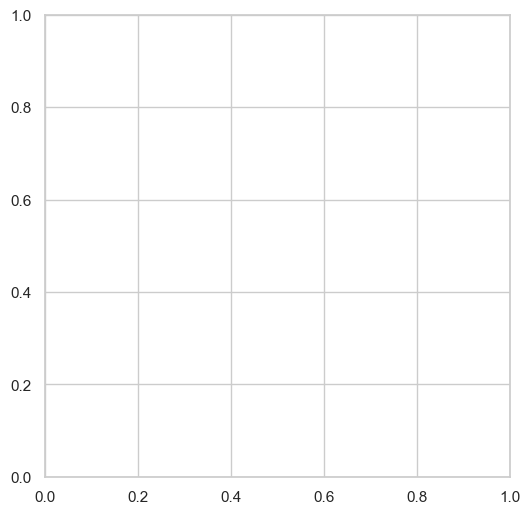

Completed: 60 steps
Run time: 0:00:00.168512
Simulation finished
Metrics: {'seed': 286460300167322870078110896050691934181, 'throughput': 0, 'avg_delay': 0.0, 'max_q_N': 2, 'max_q_S': 2, 'max_q_E': 3, 'max_q_W': 2}
Average delay: 0.0


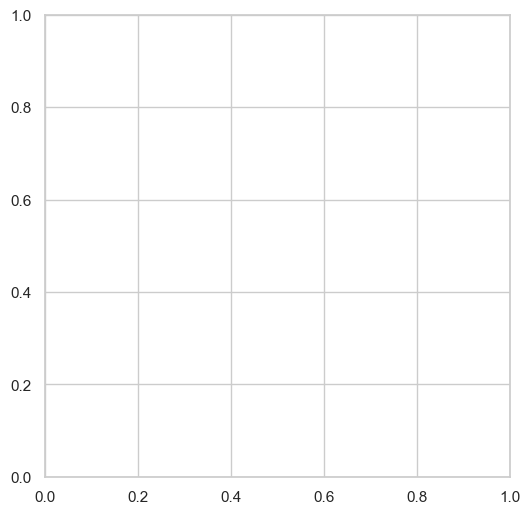

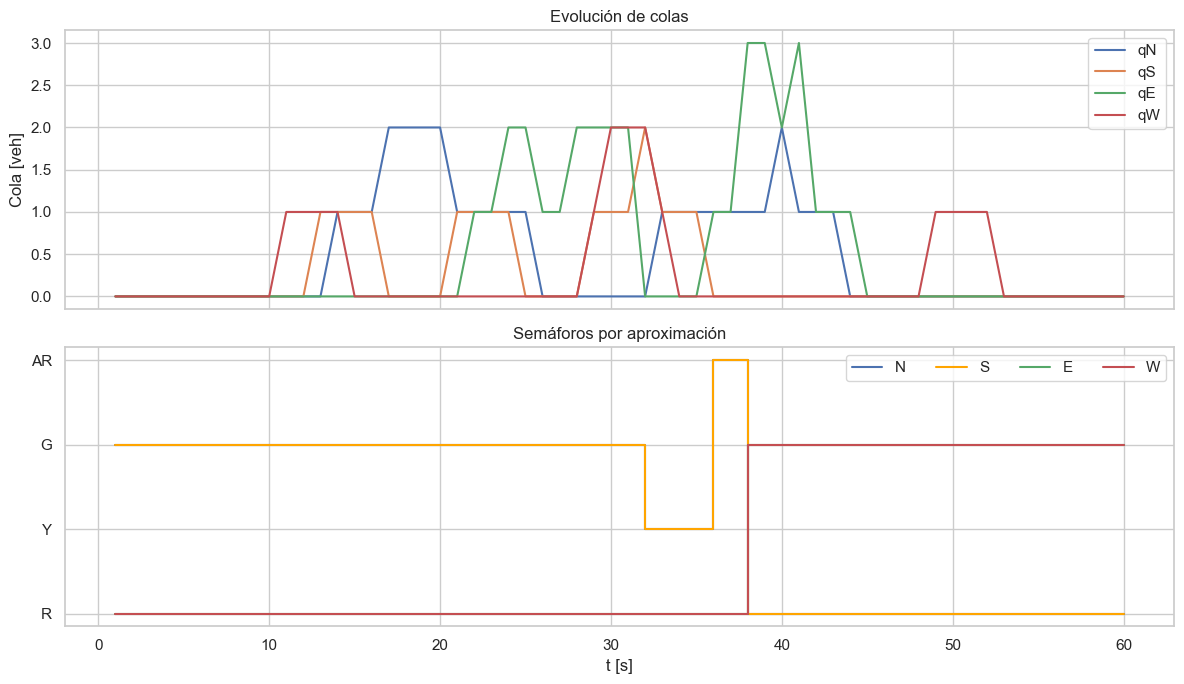

In [94]:
# Run the model for the fixed controller and then plot the metrics and graphs
fig2, ax2 = plt.subplots(figsize=(6,6))
model2 = IntersectionModel(PARAMS, controller='fixed')
model2.run()  # Run the model before accessing its outputs

# Métricas y gráficas
metrics = model2.reporters
print("Metrics:", metrics)  # This prints all reported metrics as a dictionary
print("Average delay:", metrics['avg_delay'])  # Access a specific metric if needed

dfq = model2.df_queue.copy()
fig3, ax3 = plt.subplots(2,1, figsize=(12,7), sharex=True)
for d in ['qN','qS','qE','qW']:
    ax3[0].plot(dfq['t'], dfq[d], label=d)
ax3[0].legend(); ax3[0].set_ylabel('Cola [veh]'); ax3[0].set_title('Evolución de colas')

mapv={'R':0,'Y':1,'G':2, 'AR':3} # Added 'AR' mapping
for d,c in zip(['N','S','E','W'], ['b','orange','g','r']):
    ax3[1].step(model2.df_tl['t'], model2.df_tl[d].map(mapv), where='post', color=c, label=d)
ax3[1].set_yticks([0,1,2,3]); ax3[1].set_yticklabels(['R','Y','G','AR']); ax3[1].legend(ncol=4) # Added 'AR' tick
ax3[1].set_xlabel('t [s]'); ax3[1].set_title('Semáforos por aproximación')
plt.tight_layout(); plt.show()

# **7) Correr Heurística adaptativa**

In [95]:
fig, ax = plt.subplots(figsize=(6,6))
model = IntersectionModel(PARAMS, controller='heuristic')
anim = ap.animate(model, fig, ax, my_plot)
from IPython.display import HTML
HTML(anim.to_jshtml())


In [96]:
print(dir(model.output))
# (Repite el bloque de gráficas si lo prefieres)

['__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_combine_pars', '_combine_vars', '_dict_pars_to_df', '_load', '_short_repr', '_sobol_set_df_index', 'arrange', 'arrange_reporters', 'arrange_variables', 'calc_sobol', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'load', 'pop', 'popitem', 'save', 'setdefault', 'update', 'values']


# **8) Correr Q-learning (básico)**

Entrena “en línea” durante la simulación (un episodio). Para más aprendizaje, repite varias corridas guardando model.ctrl.Q (o incrementa steps).

In [97]:
q_params = {'alpha':0.4, 'gamma':0.9, 'epsilon':0.1, 'episodes':1}
fig, ax = plt.subplots(figsize=(6,6))
model = IntersectionModel(PARAMS, controller='qlearning', q_params=q_params)
anim = ap.animate(model, fig, ax, my_plot)
from IPython.display import HTML
HTML(anim.to_jshtml())


In [98]:
print(model.output.variables.IntersectionModel)
# Puedes inspeccionar algunos Q-valores aprendidos:
Q = model.ctrl.Q
len(Q), list(Q.items())[:5]


Q-Learning Model Metrics: {'seed': 283428421625977267111595742614150799109}


Q-Learning Model Metrics: {'seed': 283428421625977267111595742614150799109}


(10,
 [((0, 0, 0), array([0., 0.])),
  ((0, 1, 0), array([-1.9065344, -2.2604288])),
  ((1, 1, 1), array([-0.8, -1.2])),
  ((1, 2, 1), array([-1.6,  0. ])),
  ((1, 2, 0), array([-1.2,  0. ]))])

# **9) Comparación rápida (baseline vs. heurística vs. Q)**

In [99]:
def run_once(controller, seed=None):
    m = IntersectionModel(PARAMS, controller=controller)
    m.run(seed=seed)
    r = m.reporters.copy()  # Use reporters instead of output.variables.IntersectionModel
    r['controller'] = controller
    return r

rows=[]
for ctrl in ['fixed','heuristic','qlearning']:
    for s in [1,2,3]:
        rows.append(run_once(ctrl, seed=s))
df = pd.DataFrame(rows)
df.groupby('controller')[['throughput','avg_delay','max_q_N','max_q_S','max_q_E','max_q_W']].mean().round(2)

Completed: 60 steps
Run time: 0:00:00.097639
Simulation finished
Completed: 60 steps
Run time: 0:00:00.059622
Simulation finished
Completed: 60 steps
Run time: 0:00:00.075940
Simulation finished
Completed: 60 steps
Run time: 0:00:00.075940
Simulation finished
Completed: 60 steps
Run time: 0:00:00.150386
Simulation finished
Completed: 60 steps
Run time: 0:00:00.150386
Simulation finished
Completed: 60 steps
Run time: 0:00:00.112315
Simulation finished
Completed: 60 steps
Run time: 0:00:00.112315
Simulation finished
Completed: 60 steps
Run time: 0:00:00.156334
Simulation finished
Completed: 60 steps
Run time: 0:00:00.156334
Simulation finished
Completed: 60 steps
Run time: 0:00:00.166958
Simulation finished
Completed: 60 steps
Run time: 0:00:00.166958
Simulation finished
Completed: 60 steps
Run time: 0:00:00.096338
Simulation finished
Completed: 60 steps
Run time: 0:00:00.074490
Simulation finished
Completed: 60 steps
Run time: 0:00:00.096338
Simulation finished
Completed: 60 steps
Run t

Completed: 60 steps
Run time: 0:00:00.097639
Simulation finished
Completed: 60 steps
Run time: 0:00:00.059622
Simulation finished
Completed: 60 steps
Run time: 0:00:00.075940
Simulation finished
Completed: 60 steps
Run time: 0:00:00.075940
Simulation finished
Completed: 60 steps
Run time: 0:00:00.150386
Simulation finished
Completed: 60 steps
Run time: 0:00:00.150386
Simulation finished
Completed: 60 steps
Run time: 0:00:00.112315
Simulation finished
Completed: 60 steps
Run time: 0:00:00.112315
Simulation finished
Completed: 60 steps
Run time: 0:00:00.156334
Simulation finished
Completed: 60 steps
Run time: 0:00:00.156334
Simulation finished
Completed: 60 steps
Run time: 0:00:00.166958
Simulation finished
Completed: 60 steps
Run time: 0:00:00.166958
Simulation finished
Completed: 60 steps
Run time: 0:00:00.096338
Simulation finished
Completed: 60 steps
Run time: 0:00:00.074490
Simulation finished
Completed: 60 steps
Run time: 0:00:00.096338
Simulation finished
Completed: 60 steps
Run t

,throughput,avg_delay,max_q_N,max_q_S,max_q_E,max_q_W
controller,,,,,,
fixed,0.0,0.0,2.33,1.00,1.67,1.33
heuristic,0.0,0.0,2.33,2.00,2.33,1.67
qlearning,0.0,0.0,2.67,1.33,1.33,2.00


# **10) Exportar a CSV (para Unity o análisis)**

In [100]:
# Exportar datos a CSV (para Unity o análisis)
# Semáforos por tick
model2.df_tl.to_csv('signal_timeline.csv', index=False)

# Posiciones de vehículos (replay) - crear el DataFrame si no existe
if hasattr(model2, 'pos_log') and model2.pos_log:
    df_pos = pd.DataFrame(model2.pos_log, columns=['t','veh_id','x','y','origin'])
    df_pos.to_csv('vehicles_positions.csv', index=False)
else:
    print("No vehicle position data to export")

# Colas
model2.df_queue.to_csv('queues.csv', index=False)

print("Data exported to CSV files:")

Data exported to CSV files:


# **Guía para el reporte PDF de la asignación**

Descripción de la técnica elegida (Heurística / Q-learning / MDP*).

Función objetivo o recompensa (qué se intenta minimizar/maximizar).

Diseño experimental: 3 demandas (baja/media/alta), ≥ 5 semillas.

Métricas: throughput, delay promedio, colas máximas.

Resultados: tablas + gráficas (colas, estados R/Y/G).

Discusión: cuándo mejora vs. plan fijo; límites y posibles mejoras.

* MDP (opcional): discretiza estados (phase, bin_ns, bin_ew), acciones {extend, switch}, estima transiciones con rollouts y aplica Value Iteration:

𝑉
(
𝑠
)
←
max
⁡
𝑎
∑
𝑠
′
𝑃
(
𝑠
′
∣
𝑠
,
𝑎
)

[
𝑅
(
𝑠
,
𝑎
,
𝑠
′
)
+
𝛾
𝑉
(
𝑠
′
)
]
V(s)←
a
max
	​

s
′
∑
	​

P(s
′
∣s,a)[R(s,a,s
′
)+γV(s
′
)]

(Implementar esto excede el tamaño del cuaderno, pero la estructura del modelo ya sirve para estimar
𝑃
P y
𝑅
R con simulación).

Checklist de “logramos la tarea”

 El controlador cambia o extiende verde según colas.

 Reporta métricas y las compara contra plan fijo.

 Muestra animación y gráficas de colas/luces.

 (Opc.) Exporta CSV para Unity.

Si deseas, te dejo una versión con parámetros del cruce asignado (tasas por dirección y tiempos mínimos/máximos) para cada equipo; solo dime los 6 cruces y lo lleno en PARAMS.